In [1]:
from os.path import join
from hipposlam.utils import read_pickle

In [2]:

base_dir = r'D:'
project_tag = 'ImageSamplingHippoSeq'
project_dir = join(base_dir, 'data', project_tag)
save_hipposlam_pth = join(project_dir, 'hipposlam.pickle')
save_trajdata_pth = join(project_dir, 'trajdata.pickle')
save_img_dir = join(project_dir, 'imgs')

In [3]:
traj_data = read_pickle(save_trajdata_pth)

In [1]:
traj_data[3]


NameError: name 'traj_data' is not defined

In [40]:
from hipposlam.utils import read_pickle, save_pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import torch
from os.path import join

In [20]:
model = PPO.load('data/StateMapLearnerVAEEmbedding/PPO1.zip')

In [26]:
model.predict(2, deterministic=True)

(array(3, dtype=int64), None)

In [39]:
state = torch.Tensor([2]).to(torch.int64)
with torch.no_grad():
    aprobs = model.policy.get_distribution(state).distribution.probs.numpy()
    
aprobs
    

array([[0.02433794, 0.04791303, 0.43873218, 0.48901686]], dtype=float32)

In [48]:
def get_policy(model, states):
    """
    
    Parameters
    ----------
    model
    states

    Returns
    -------
    aprobs : numpy.array
        (N, 4)
    """
    with torch.no_grad():
        aprobs = model.policy.get_distribution(torch.from_numpy(states)).distribution.probs.numpy()
    return aprobs

In [50]:
foo = np.arange(9).reshape(3, 3)
foo2 = []


foo2.extend(foo)
foo2

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7, 8])]

In [56]:
trajkeys = 't', 'x', 'y', 'a', 'sid', 'r', 'terminated', 'truncated', 'embedid', 'aprobs', 'action'
alltrajdict = {key:[] for key in trajkeys}
allfsigmalist = []
max_chpt_num = 6
project_name = 'StateMapLearnerVAEEmbedding'
project_dir = join('data', project_name)
for i in range(5, max_chpt_num+1):
    traj_data_pth = join(project_dir, 'PPO%d_trajdata.pickle'%i)
    model_pth = join(project_dir, 'PPO%d.zip'%i)
    trajdict_list = read_pickle(traj_data_pth)  # a list of dictionaries, each for one episode
    model = PPO.load(model_pth)
    
    states_np = np.concatenate([ np.array(traj['sid']) for traj in trajdict_list])
    aprobs_np = get_policy(model, states_np)
    for trajdict in trajdict_list:
        # Traj data
        for key in trajkeys[:-2]:
            alltrajdict[key].extend(trajdict[key])
        # Fsigma
        allfsigmalist.extend(trajdict['fsigma'])
        
    alltrajdict['aprobs'].extend(aprobs_np)
    alltrajdict['action'].extend(np.argmax(aprobs_np, axis=1))
alltrajdf = pd.DataFrame(alltrajdict)
print(alltrajdf.shape)


(52271, 11)


In [55]:
alltrajdf

,t,x,y,a,sid,r,terminated,truncated,embedid,aprobs
0,1,-11.550425,7.091877,-1.485622,1,0.00,False,False,0,"[0.13196972, 0.0026316314, 0.04474435, 0.8206543]"
1,1,-11.662448,7.374437,2.080096,2,0.00,False,False,1,"[0.0003320071, 0.0005676974, 0.8738472, 0.1252..."
2,2,-11.743144,7.472918,2.745601,2,0.00,False,False,1,"[0.0003320071, 0.0005676974, 0.8738472, 0.1252..."
3,3,-11.818010,7.569246,2.092530,2,0.00,False,False,1,"[0.0003320071, 0.0005676974, 0.8738472, 0.1252..."
4,4,-11.732468,7.715233,1.074201,2,0.00,False,False,1,"[0.0003320071, 0.0005676974, 0.8738472, 0.1252..."
...,...,...,...,...,...,...,...,...,...,...
52266,201,-7.271576,-8.144572,3.141083,191,0.00,False,False,191,"[0.9055028, 0.012951297, 0.076868184, 0.004677..."
52267,202,-7.271576,-8.144257,3.141076,191,0.00,False,False,191,"[0.9055028, 0.012951297, 0.076868184, 0.004677..."
52268,203,-7.271576,-8.143939,3.141071,191,0.00,False,False,191,"[0.9055028, 0.012951297, 0.076868184, 0.004677..."
52269,204,-7.271576,-8.143618,3.141066,191,0.00,False,False,191,"[0.9055028, 0.012951297, 0.076868184, 0.004677..."


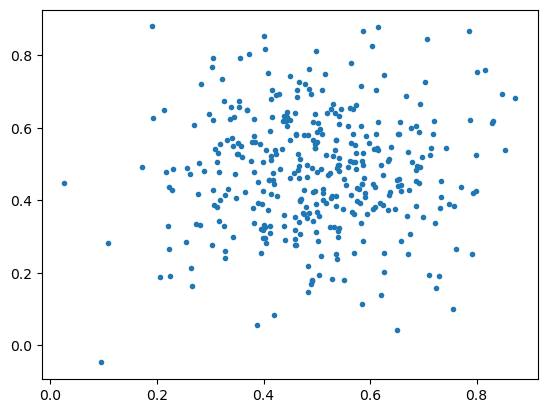

In [13]:
hipposlam = read_pickle("data/StateMapLearnerVAEEmbedding/PPO5_hipposlam.pickle")
emins = np.array([-0.05857748, -0.04856893, -0.06281231, -0.04864687, -0.06528954, -0.04759025
                          , -0.04975088, -0.05158772, -0.05236586, -0.05695376, -0.05058779, -0.05228593
                          , -0.04907009, -0.04240562, -0.05837312, -0.05977833, -0.0470208, -0.05325105
                          , -0.07136835, -0.04415521, -0.05362874, -0.04605735, -0.05209879, -0.05079487
                          , -0.05764247])
emaxs = np.array([0.05367929, 0.05403634, 0.05754889, 0.04407845, 0.0555541, 0.05130836
                          , 0.05649689, 0.05994137, 0.0528358, 0.05752638, 0.05975122, 0.04709101
                          , 0.04978276, 0.04952971, 0.04652157, 0.05359203, 0.05894629, 0.05700714
                          , 0.05703947, 0.05323942, 0.05871239, 0.05809979, 0.05312897, 0.05034185
                          , 0.05146259])
embeds = np.stack(hipposlam['hippomap'].sid2embed)
e_mat_norm = (embeds - emins) / (emaxs - emins)
plt.scatter(e_mat_norm[:,0], e_mat_norm[:, 1], marker='.')

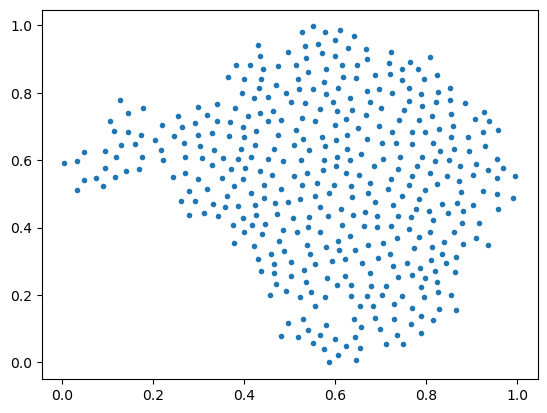

In [14]:
hipposlam = read_pickle("data/StateMapLearnerUmapEmbedding_NewRecord/PPO2_hipposlam.pickle")
emins = np.array([-17.670673, -16.776457])
emaxs = np.array([12.743417, 12.321048])
embeds = np.stack(hipposlam['hippomap'].sid2embed)
e_mat_norm = (embeds - emins) / (emaxs - emins)
plt.scatter(e_mat_norm[:,0], e_mat_norm[:, 1], marker='.')


In [15]:
subtrajdf = alltrajdf


Number of unique states = 362


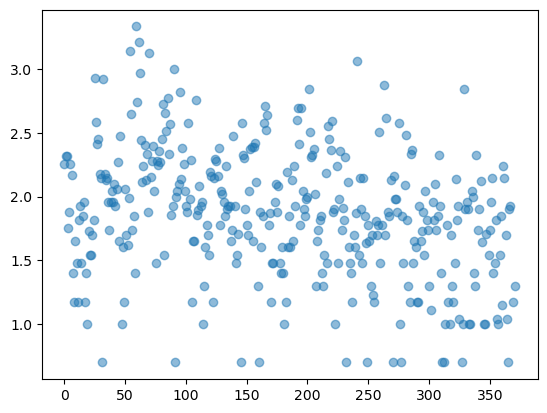

In [16]:
sid = alltrajdf['embedid']
unique_sids, unique_counts = np.unique(alltrajdf['embedid'], return_counts=True)
print('Number of unique states = %d'%(unique_sids.shape[0]))

plt.scatter(unique_sids, np.log10(unique_counts), alpha=0.5)

C:\Users\Hoi\AppData\Local\Temp\ipykernel_8432\3871847826.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 3))


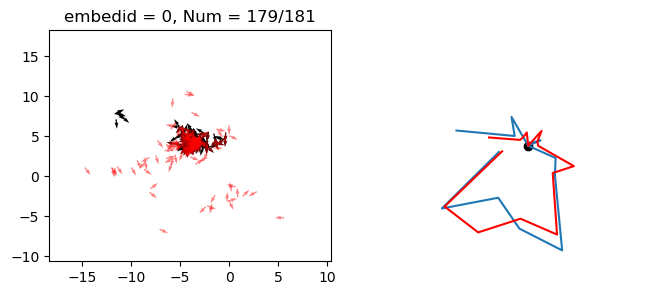

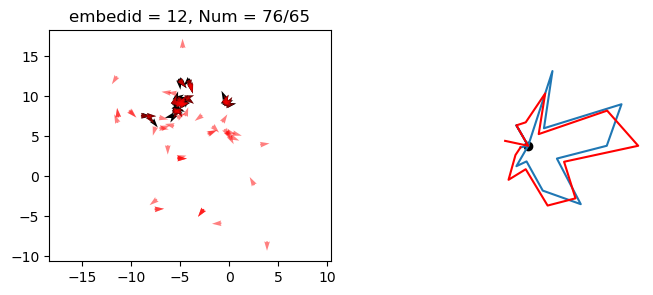

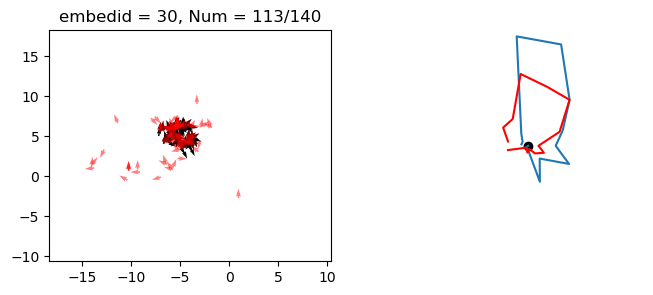

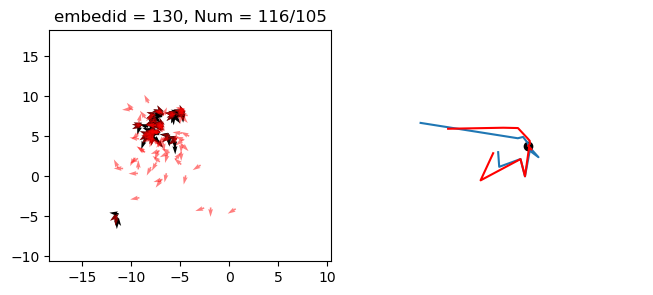

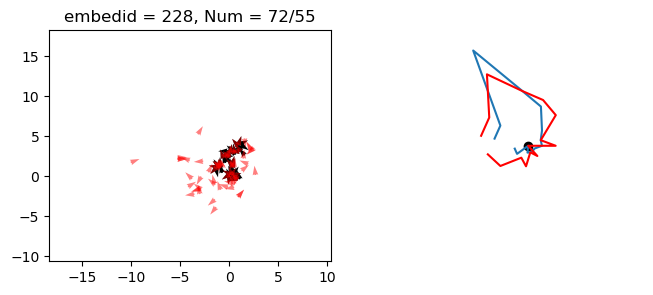

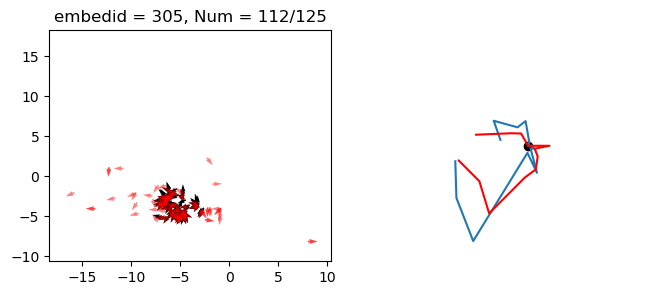

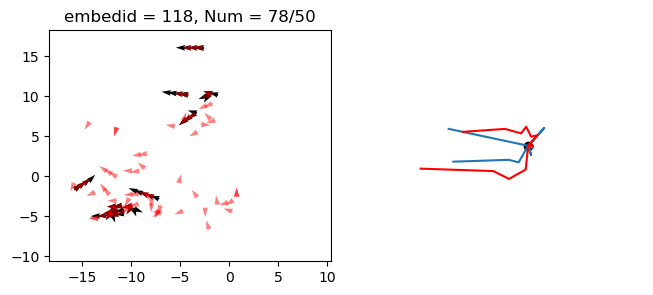

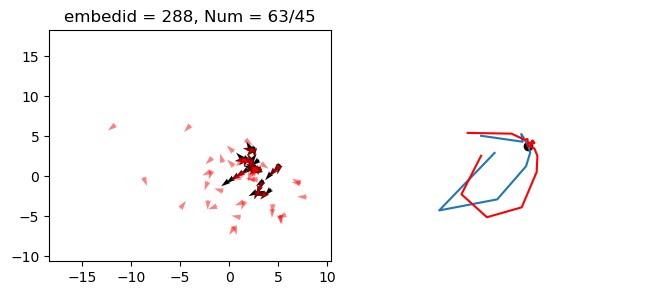

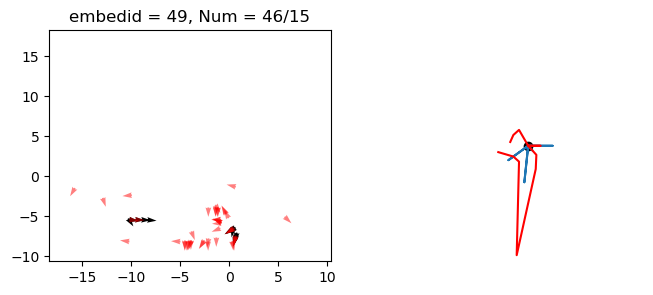

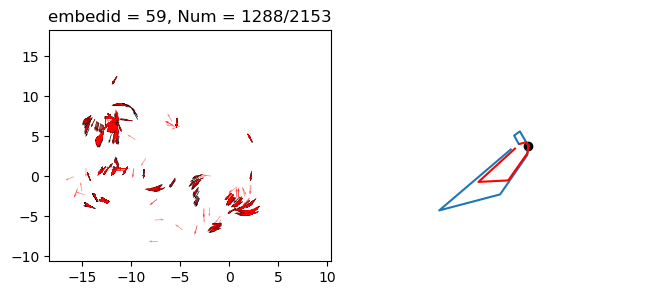

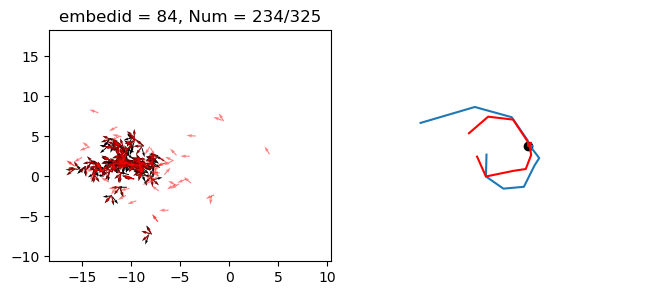

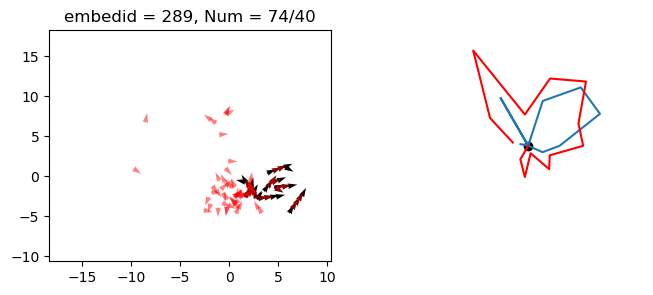

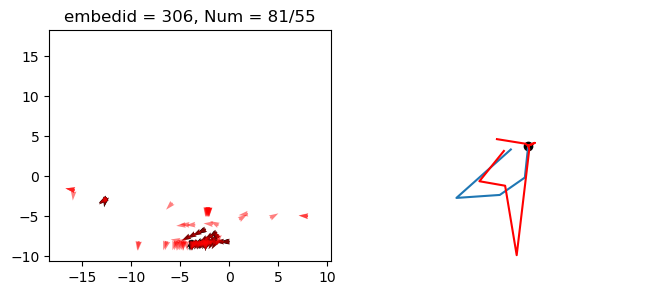

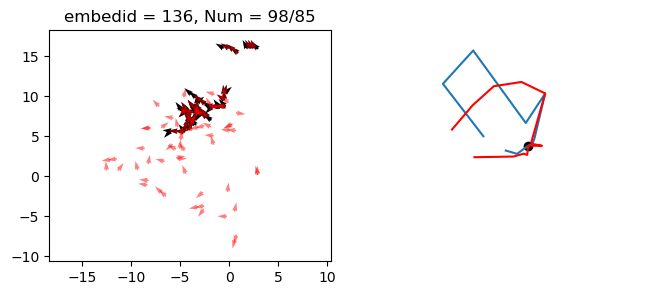

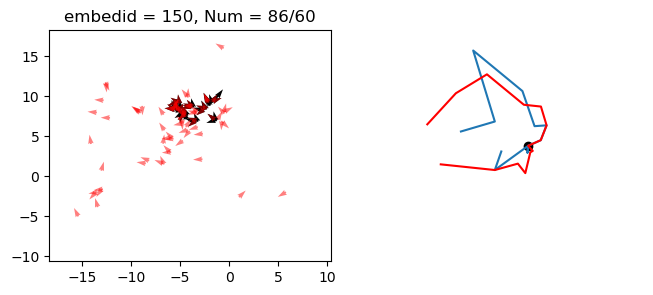

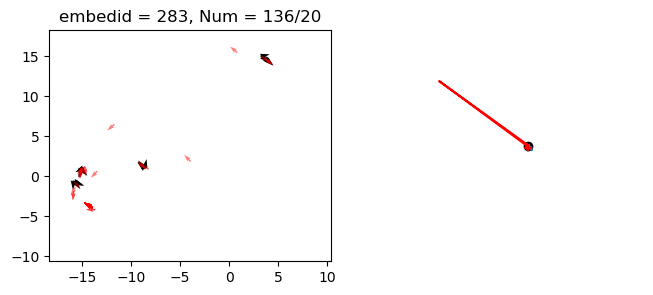

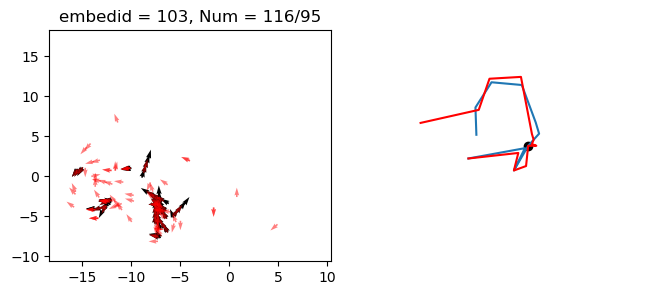

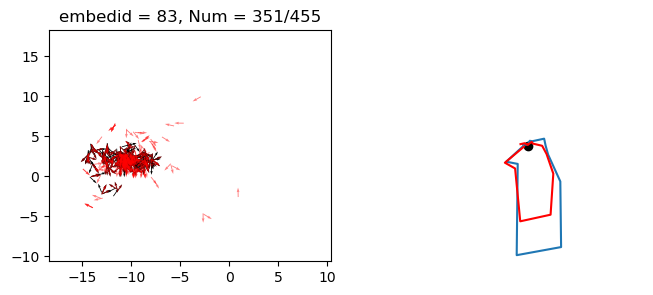

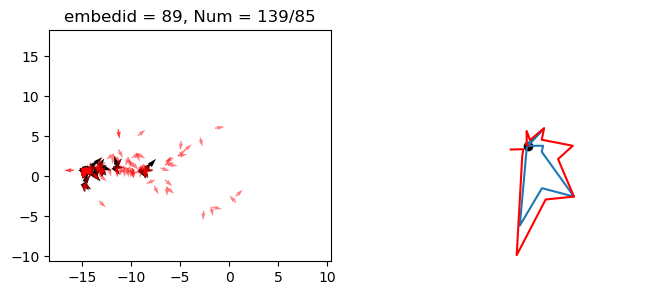

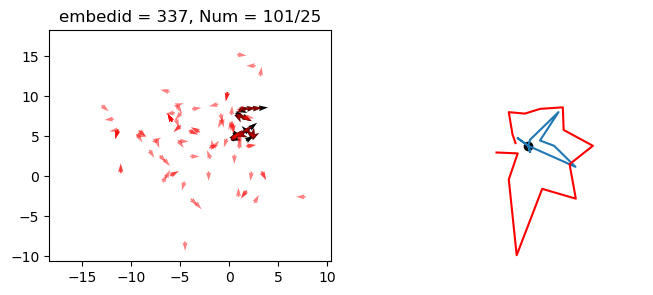

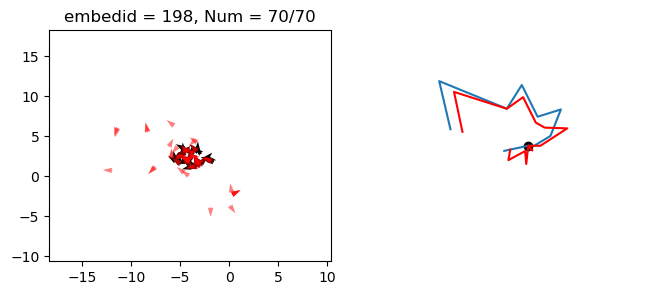

In [17]:
xbound = (-18.4, 10.4)
ybound = (-10.6, 18.2)
aedges = np.linspace(-np.pi, np.pi, 16)
axm = aedges[:-1]/ 2 + aedges[1:] / 2

unique_embedids = np.unique(subtrajdf['embedid'])


selected_embedids = np.random.choice(unique_embedids, 20, replace=False)

for embedid in np.append(0, selected_embedids):

    mask_embed = subtrajdf['embedid'] == embedid
    mask_sid = subtrajdf['sid'] == embedid
    
    
    subsubdf_embed = subtrajdf[mask_embed]
    x_embed = subsubdf_embed['x'].to_numpy()
    y_embed = subsubdf_embed['y'].to_numpy()
    a_embed = subsubdf_embed['a'].to_numpy()
    
    subsubdf_sid = subtrajdf[mask_sid]
    x_sid = subsubdf_sid['x'].to_numpy()
    y_sid = subsubdf_sid['y'].to_numpy()
    a_sid = subsubdf_sid['a'].to_numpy() 
    
    
    
    fig = plt.figure(figsize=(8, 3))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2, projection='polar')


    ax0.quiver(x_embed, y_embed, np.cos(a_embed), np.sin(a_embed), scale=30)
    ax0.quiver(x_sid, y_sid, np.cos(a_sid), np.sin(a_sid), scale=30, color='r', alpha=0.5)
    ax0.set_xlim(*xbound)
    ax0.set_ylim(*ybound)
    ax0.set_title('embedid = %d, Num = %d/%d'%(embedid, mask_sid.sum(), mask_embed.sum()))

    abins_embed,_  = np.histogram(a_embed, bins=aedges )
    abins_sid,_  = np.histogram(a_sid, bins=aedges )
    ax1.plot(axm, abins_embed)
    ax1.plot(axm, abins_sid, color='r')
    ax1.scatter(0, 0, c='k')
    ax1.axis('off')
    
